Hodrick-Prescott filtering is a filtering method. A *filtering method* can be used to find $x_t$ given $x_1,\dots,x_t$. In this post we will go through a simple filtering example with Hodrick-Prescott filtering. <!--more-->

However Hodrick-Prescott seems in my view most useful as an offline *smoothing method* e.g. for finding $x_t$ given $x_1,\dots,x_T$ for $1\leq t\leq T$.

A good article about the related $l_1$ trend filtering and this filtering method is found in [1].

In Hodrick-Prescott filtering, the trend estimate $x_t$ is chosen to minimize the objective function:
    
$$
\begin{aligned}
L(x) 
&= \frac{1}{2}\sum_{t=1}^{n}(y_t - x_t)^2 + \lambda \sum_{t=1}^{n-1}(x_{t-1} - 2x_t + x_{t+1})^2 \\
&= \frac{1}{2}\lVert y - x \rVert_2 ^ 2 + \lambda \lVert Dx \rVert_2 ^ 2 \\
&= \frac{1}{2} (y - x) ^ T (y - x) + \lambda x^TD^TDx \\
&= \frac{1}{2} (y^Ty + x^Tx - 2x^ Ty) + \lambda x^TD^TDx
\end{aligned}
$$

Where 

$$
D = 
\begin{bmatrix}
1&-2&1\cr
&1&-2&1\cr
&&\ddots&&\ddots\cr
&&&1&-2&1\cr
&&&&1&-2&1\cr
\end{bmatrix}
$$

The second part of the objective function:

$$
\lambda \sum_{t=1}^{n-1}(x_{t-1} - 2x_t + x_{t+1})^2
$$

Is a term penalizing the central difference estimate of the second derivative:

$$
x_{t-1} - 2x_t + x_{t+1} = \frac{\frac{x_{t-1} - x_t}{1} - \frac{x_t - x_{t+1}}{1}}{1}
$$

Assuming a constant difference of $1$ between the observations. If the difference between the observations is a different, but still constant value, $h$ then 

$$
\frac{\frac{x_{t-1} - x_t}{h} - \frac{x_t - x_{t+h}}{h}}{h} = \frac{1}{h^2}(x_{t-1} - 2x_t + x_{t+1})
$$

The $h$ be factored to the regularization parameter $\lambda$ e.g.

$$
\begin{aligned}
\frac{1}{2}\sum_{t=1}^{n}(y_t - x_t)^2 + \eta \sum_{t=1}^{n-1}(\frac{1}{h^2}(x_{t-1} - 2x_t + x_{t+1}))^2 
&= \frac{1}{2}\sum_{t=1}^{n}(y_t - x_t)^2 + \frac{\eta}{h^4} \sum_{t=1}^{n-1}(x_{t-1} - 2x_t + x_{t+1})^2 \\
&= \frac{1}{2}\sum_{t=1}^{n}(y_t - x_t)^2 + \lambda \sum_{t=1}^{n-1}(x_{t-1} - 2x_t + x_{t+1})^2
\end{aligned}
$$

If $\lambda = \frac{\eta}{h^4}$. The right hand side is now the same objective function but wrt. a central difference estimate with constant difference $h$ between the observations. 

The optimal value can be find by setting the derivative to $0$, because the objective is strictly convex.

$$
\begin{aligned}
\frac{\partial}{\partial x} L(x)
&= \frac{\partial}{\partial x} (\frac{1}{2} (y^Ty + x^Tx - 2x^ Ty) + \lambda x^TD^TDx) \\
&= \frac{1}{2} \frac{\partial}{\partial x} ( x^Tx - 2x^ Ty) + \lambda \frac{\partial}{\partial x} x^TD^TDx \\
&= \frac{1}{2}( 2 x - 2y) + \lambda 2 D^TDx \\
&= x - y + \lambda 2 D^TDx \\
&= 0 \\
&\Downarrow \\
y
&= x + \lambda 2 D^TDx \\
&= (I + \lambda 2 D^TD) x \\
&\Downarrow \\
x &= (I + \lambda 2 D^TD)^{-1}y
\end{aligned}
$$

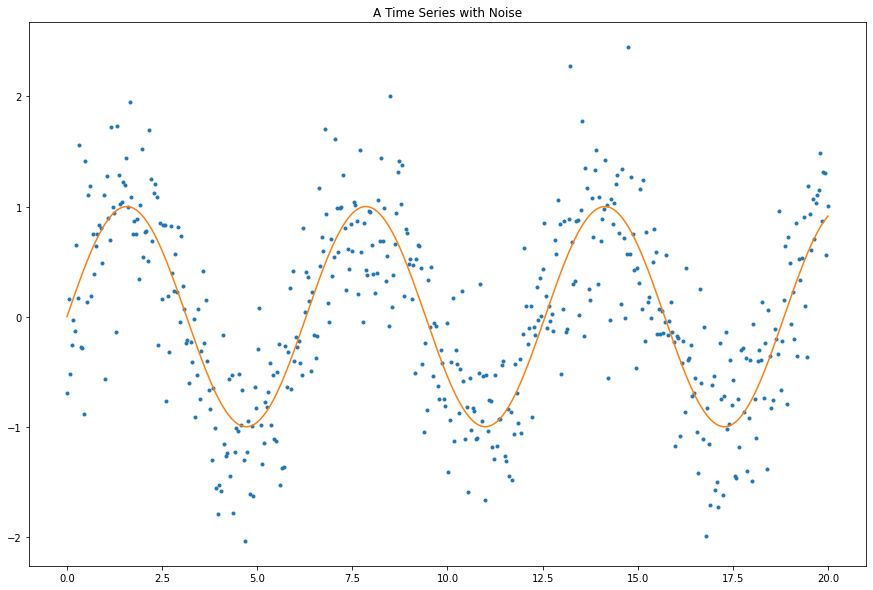

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Standard deviation of the gaussian noise.
EPS = 0.05

# Number of observations
N = 500

# Regularization parameter.
ETA = 0.05

# The size of the interval from [0, B].
B = 20

t = np.linspace(0, B, num=N)
h = np.diff(t)[0]
x = np.sin(t)
eps = np.random.normal(scale=0.5, size=N)
y = x + eps

plt.figure(figsize=(15, 10))
plt.plot(t, y, '.')
plt.plot(t, x, '-')
plt.title("A Time Series with Noise")
plt.show()

Lets start by creating the matrix $D$.

In [2]:
D = np.zeros((N-2, N))
for i in range(N-2):
    D[i, i:i+3] = [1, -2, 1]
D

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

We can now calculate what we will call the *projection matrix* $P = (I + \lambda 2 D^TD)^{-1}$, because it is very similar to the projection matrix in linear regression (probably the same in some sense).

In [3]:
P = np.linalg.inv(np.eye(N) + 2 * ETA / h ** 4 * D.T.dot(D))
P

array([[9.59020654e-02, 9.10718484e-02, 8.62649624e-02, ...,
        2.16669024e-12, 2.15885073e-12, 2.15095572e-12],
       [9.10718484e-02, 8.67281902e-02, 8.23821818e-02, ...,
        2.15001117e-12, 2.15445881e-12, 2.15885073e-12],
       [8.62649624e-02, 8.23821818e-02, 7.84971751e-02, ...,
        2.13327619e-12, 2.15001117e-12, 2.16669024e-12],
       ...,
       [2.16669024e-12, 2.15001117e-12, 2.13327619e-12, ...,
        7.84971751e-02, 8.23821818e-02, 8.62649624e-02],
       [2.15885073e-12, 2.15445881e-12, 2.15001117e-12, ...,
        8.23821818e-02, 8.67281902e-02, 9.10718484e-02],
       [2.15095572e-12, 2.15885073e-12, 2.16669024e-12, ...,
        8.62649624e-02, 9.10718484e-02, 9.59020654e-02]])

Now we project our observed values to get the *smoothed* values $x^{hp}$.

In [4]:
x_hp = P.dot(y)

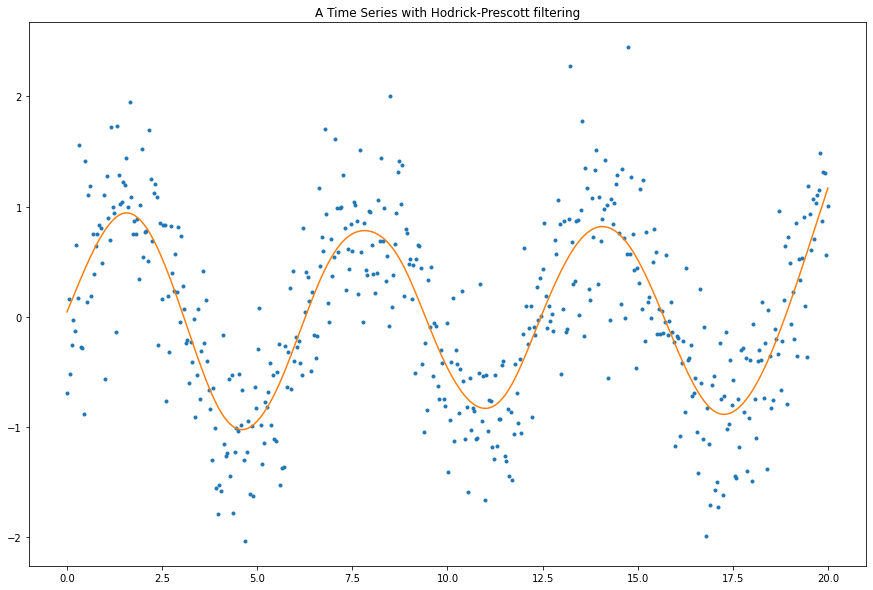

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(t, y, '.')
plt.plot(t, x_hp, '-')
plt.title("A Time Series with Hodrick-Prescott filtering")
plt.show()

As the regularization parameter is increased the line becomes more smooth.

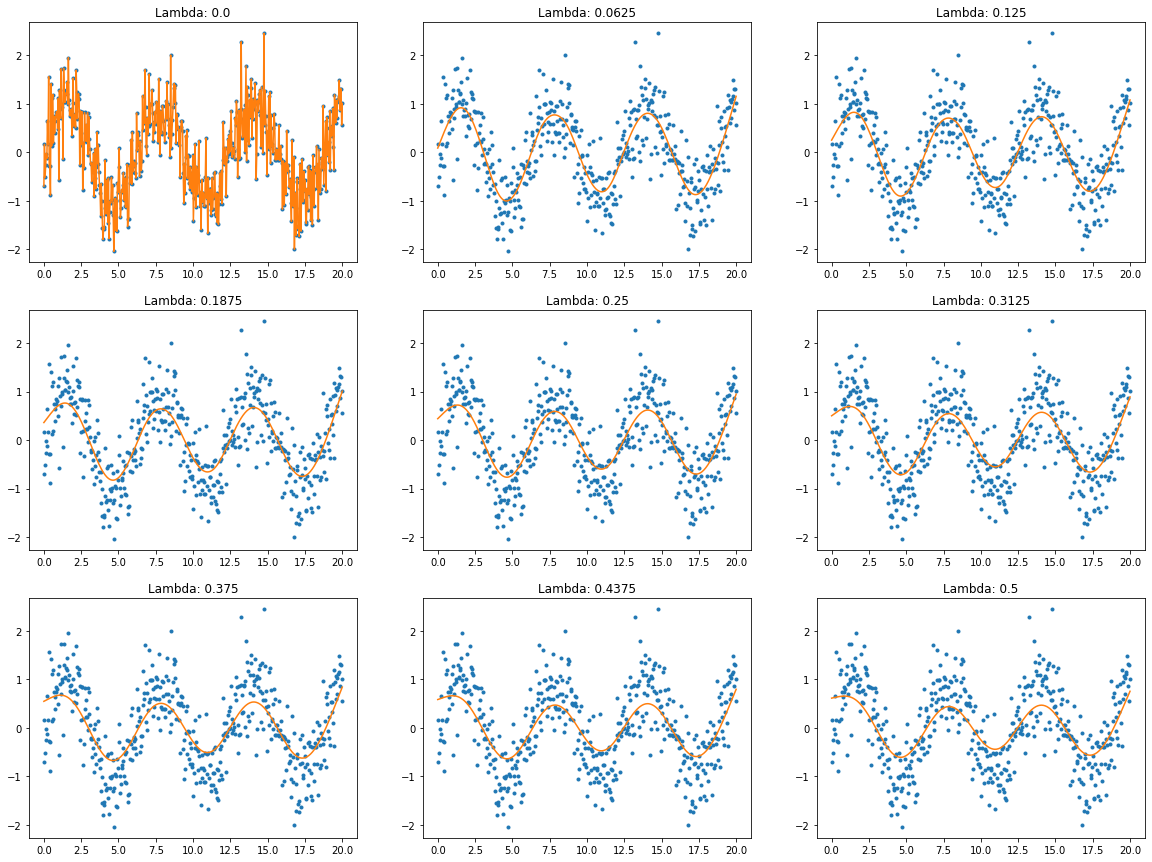

In [6]:
plt.figure(figsize=(20, 15))
for idx, eta in enumerate(np.linspace(0, 0.5, 9)):
    plt.subplot(3, 3, idx + 1)
    P = np.linalg.inv(np.eye(N) + 2 * eta / h ** 4 * D.T.dot(D))
    x_hp = P.dot(y)
    plt.plot(t, y, '.')
    plt.plot(t, x_hp, '-')
    plt.title(f"Lambda: {round(eta, 4)}")
plt.show()

In the limit it is a straight line.

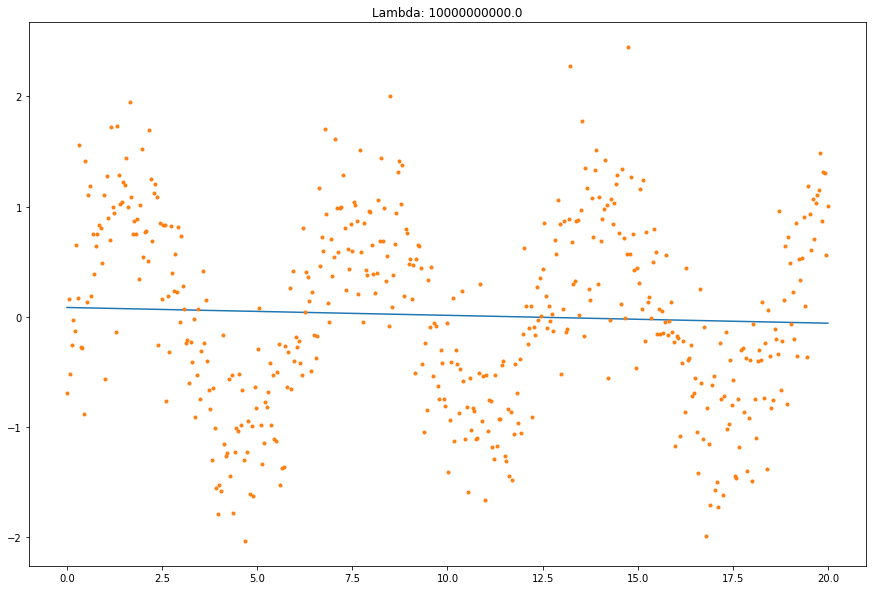

In [7]:
plt.figure(figsize=(15, 10))
P = np.linalg.inv(np.eye(N) + 2 * 1e10 / h ** 4 * D.T.dot(D))
x_hp = P.dot(y)
plt.plot(t, x_hp, '-')
plt.plot(t, y, '.')
plt.title(f"Lambda: {1e10}")
plt.show()

# Online Version

My take on an online version of this filtering method. In this online version one fixes the size of the projection matrix it iterativly on a fifo queue of the signal $y$ taking the midpoint in each iteration of the projected values in each iteration.

In [8]:
# Number of observations
N_ONLINE = 50

# Regularization parameter.
ETA_ONLINE = 0.05

Construct an online version on the projection matrix with a fixed size.

In [9]:
D_online = np.zeros((N_ONLINE-2, N_ONLINE))
for i in range(N_ONLINE-2):
    D_online[i, i:i+3] = [1, -2, 1]
P_online = np.linalg.inv(np.eye(N_ONLINE) + 2 * ETA_ONLINE / h ** 4 * D_online.T.dot(D_online))

Run the projection online and use the midpoint as the filtered value, will result in a shifted time series.

In [10]:
x_hp_online = []
for i in range(N_ONLINE, len(y)):
    x_new = P_online.dot(y[i-N_ONLINE:i])
    x_hp_online.append(x_new[N_ONLINE // 2])
x_hp_online = np.array(x_hp_online)

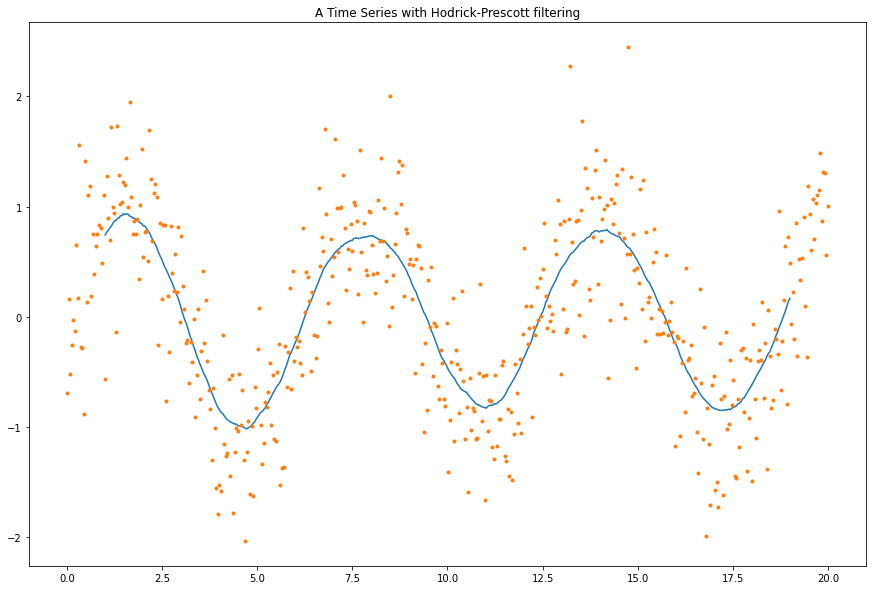

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(t[N_ONLINE // 2:-N_ONLINE // 2] , x_hp_online, '-')
plt.plot(t, y, '.')
plt.title("A Time Series with Hodrick-Prescott filtering")
plt.show()

# References

[1] http://www.optimization-online.org/DB_FILE/2007/09/1791.pdf